Library

In [46]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns



#Data Understanding

In [3]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

print('Jumlah data link movie : ', len(links.movieId.unique()))
print('Jumlah data movie : ', len(movies.movieId.unique()))
print('Jumlah data ratings dari user : ', len(ratings.userId.unique()))
print('Jumlah data ratings dari user : ', len(ratings.movieId.unique()))
print('Jumlah data : ', len(tags.movieId.unique()))


Jumlah data link movie :  9742
Jumlah data movie :  9742
Jumlah data ratings dari user :  610
Jumlah data ratings dari user :  9724
Jumlah data :  1572


#Univariate Exploratory Data Analysis
Variabel-variabel pada movie-recommendation-data adalah sebagai berikut :

Link: adalah daftar tautan film tersebut.   
Film: adalah daftar film yang tersedia.   
Rating: adalah daftar penilaian yang diberikan oleh pengguna untuk film-film tersebut.  
Tag: adalah daftar kata kunci untuk film-film tersebut.

Semua variable ini akan digunakan dalam pembuatan sistem rekomendasi content-based filtering.

In [4]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [6]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [12]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [13]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [15]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [16]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [17]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [18]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


berdasarkan deskripsi ratings diatas didapatkan informasi bahwa nilai minimum rating adalah 0,5 dan maksimal 5 sehingga skala ratingnya 0,5-5

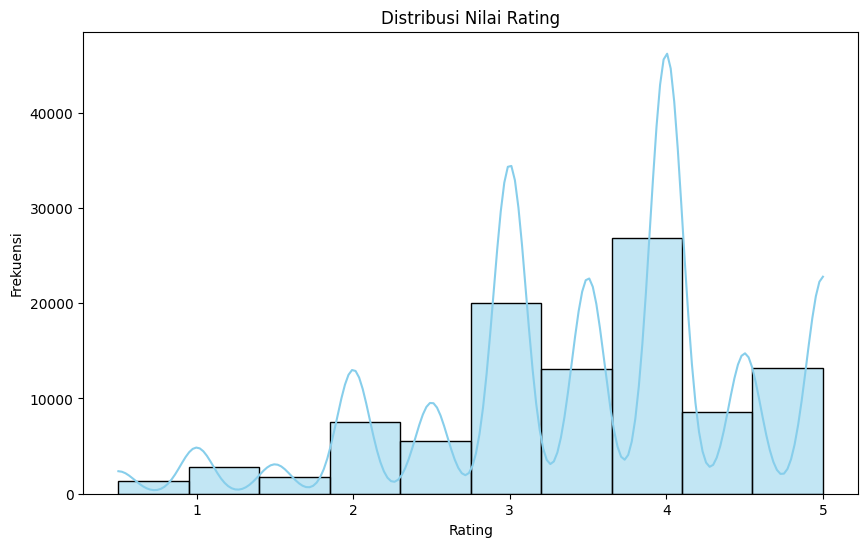

In [47]:
# Distribusi nilai rating
plt.figure(figsize=(10, 6))
sns.histplot(ratings['rating'], bins=10, kde=True, color='skyblue')
plt.title('Distribusi Nilai Rating')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

berdasarkan informasi dari diagram bar diatas menunjukan bahwa ratings terdistribusi dengan baik dalam skala 0,5-5 dan rating paling banyak diberikan pada kisaran 4

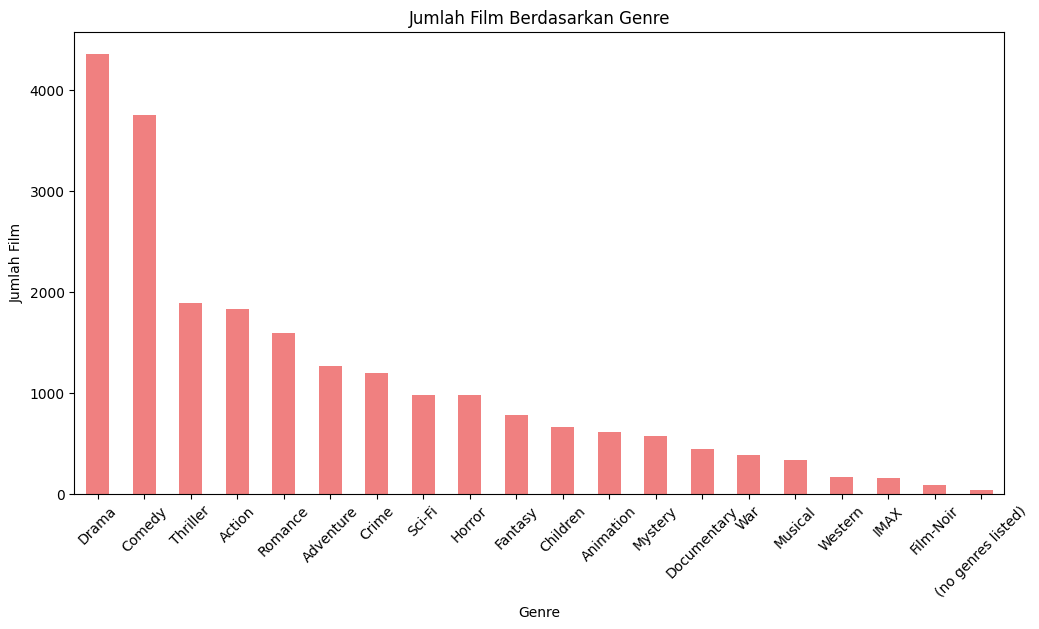

In [48]:
# Jumlah film berdasarkan genre
genre_count = movies['genres'].str.split('|').explode().value_counts()
plt.figure(figsize=(12, 6))
genre_count.plot(kind='bar', color='lightcoral')
plt.title('Jumlah Film Berdasarkan Genre')
plt.xlabel('Genre')
plt.ylabel('Jumlah Film')
plt.xticks(rotation=45)
plt.show()

berdasarkan diagram bar dari jumlah film berdasarkan genre terdapat informasi bahwa film dengan genre drama menempati posisi pertama dalam jumlah filmnya. kemudian terdapat informasi bahwa ada filmnya yang tidak memiliki genre. Hal ini dapat membuat model yang akan dibuat terganggu karena terdapat anomali pada data tersebut, maka harus dilakukan pembersihan data sebelum data di buat model.

#Multivariate Exploratory Data Analysis

<ipython-input-51-ed7b9d1697c2>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=movies_ratings, x='genre_list', y='rating', palette='Set3')


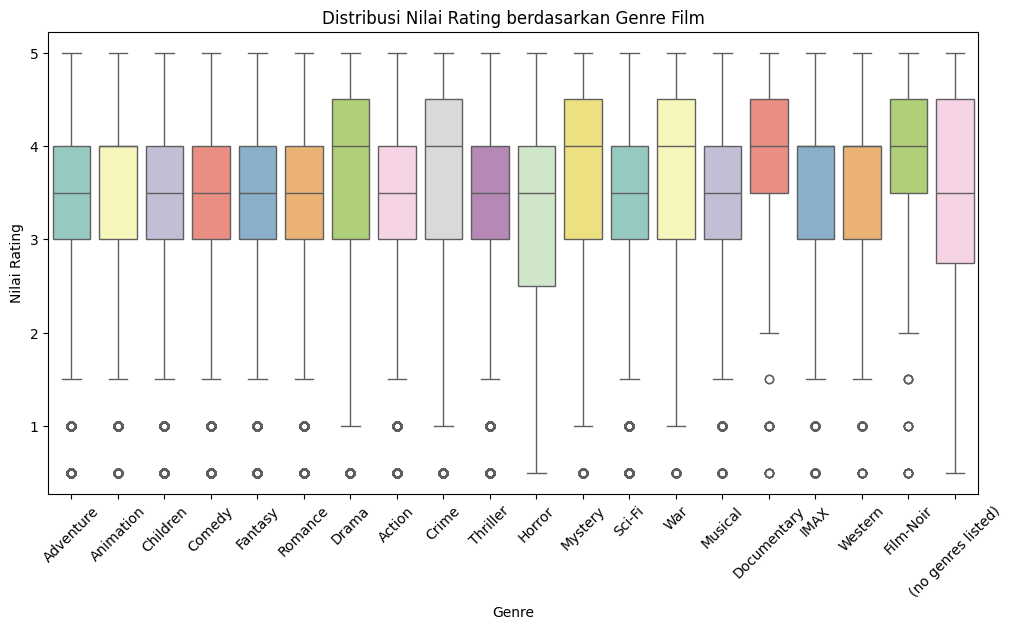

In [51]:
# Gabungkan data movies dengan data ratings
movies_ratings = pd.merge(movies, ratings, on='movieId')

# Explode genre menjadi baris baru untuk setiap genre dalam list
movies_ratings['genre_list'] = movies_ratings['genres'].str.split('|')
movies_ratings = movies_ratings.explode('genre_list')

# Buat box plot untuk distribusi nilai rating berdasarkan genre
plt.figure(figsize=(12, 6))
sns.boxplot(data=movies_ratings, x='genre_list', y='rating', palette='Set3')
plt.title('Distribusi Nilai Rating berdasarkan Genre Film')
plt.xlabel('Genre')
plt.ylabel('Nilai Rating')
plt.xticks(rotation=45)
plt.show()


berdasarkan diagram boxplot dihasilkan informasi bahhwa korelasi antara genre dan rating memiliki hal yang kuat, terbukti pada genre documentary dan film-noir, kedua film ini mendapati ratings yang cenderung tinggi sedangkan genre lain hampir mirip persebaran ratingsnya

#Data Processing

##Menggabungkan MovieID
Fungsi ini digunakan untuk menggabungkan semua ID film dari empat dataframe yang berbeda (links, movies, ratings, dan tags) ke dalam satu array tunggal. Kemudian, array tersebut diurutkan dan data yang sama dihapus. Tujuannya adalah untuk menciptakan daftar yang unik dari semua ID film yang terdapat dalam dataset. Hasil akhirnya adalah daftar yang berisi semua ID film yang berbeda dalam dataset tersebut

In [19]:
# Menggabungkan seluruh movieID pada kategori movie
movie_all = np.concatenate((
    links.movieId.unique(),
    movies.movieId.unique(),
    ratings.movieId.unique(),
    tags.movieId.unique(),
))

# Mengurutkan data dan menghapus data yang sama
movie_all = np.sort(np.unique(movie_all))

print('Jumlah seluruh data movie berdasarkan movieID: ', len(movie_all))

Jumlah seluruh data movie berdasarkan movieID:  9742


## Menggabungkan userID
Fungsi ini digunakan untuk menggabungkan semua ID pengguna dari dua dataframe yang berbeda (ratings dan tags) ke dalam satu array tunggal. Kemudian, array tersebut diurutkan dan data yang sama dihapus. Tujuannya adalah untuk menciptakan daftar yang unik dari semua ID pengguna yang terdapat dalam dataset. Hasil akhirnya adalah daftar yang berisi semua ID pengguna yang berbeda dalam dataset tersebut.

In [20]:
# Menggabungkan seluruh userId
user_all = np.concatenate((
    ratings.userId.unique(),
    tags.userId.unique(),

))

# Menghapus data yang sama kemudian mengurutkannya
user_all = np.sort(np.unique(user_all))

print('Jumlah seluruh user: ', len(user_all))

Jumlah seluruh user:  610


menggabungkan beberapa dataframe untuk menyatukan informasi tentang film dan penilaian pengguna ke dalam satu dataframe tunggal. Ini memungkinkan untuk menganalisis data penilaian film bersama dengan informasi detail tentang setiap film.

In [21]:
movie_info = pd.concat([links, movies, ratings, tags])
movie = pd.merge(ratings, movie_info , on='movieId', how='left')
movie

,userId_x,movieId,rating_x,timestamp_x,imdbId,tmdbId,title,genres,userId_y,rating_y,timestamp_y,tag
0,1,1,4.0,964982703,114709.0,862.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,4.0,964982703,NaN,NaN,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN,NaN,NaN
2,1,1,4.0,964982703,NaN,NaN,NaN,NaN,1.0,4.0,9.649827e+08,NaN
3,1,1,4.0,964982703,NaN,NaN,NaN,NaN,5.0,4.0,8.474350e+08,NaN
4,1,1,4.0,964982703,NaN,NaN,NaN,NaN,7.0,4.5,1.106636e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6359580,610,170875,3.0,1493846415,4630562.0,337339.0,NaN,NaN,NaN,NaN,NaN,NaN
6359581,610,170875,3.0,1493846415,NaN,NaN,The Fate of the Furious (2017),Action|Crime|Drama|Thriller,NaN,NaN,NaN,NaN
6359582,610,170875,3.0,1493846415,NaN,NaN,NaN,NaN,50.0,1.0,1.514498e+09,NaN
6359583,610,170875,3.0,1493846415,NaN,NaN,NaN,NaN,249.0,3.0,1.505165e+09,NaN


berdasarkan hasil dari penggabungan dataframe didapatin hasil bahwa terdapat nilai yang hilang

In [22]:
movie.isnull().sum()

userId_x             0
movieId              0
rating_x             0
timestamp_x          0
imdbId         6258749
tmdbId         6258762
title          6258749
genres         6258749
userId_y        201672
rating_y        434885
timestamp_y     201672
tag            6126372
dtype: int64

menghitung jumlah nilai null (nilai yang hilang) dalam setiap kolom dari dataframe movie.

In [23]:
movie.groupby('movieId').sum()

,userId_x,rating_x,timestamp_x,imdbId,tmdbId,title,genres,userId_y,rating_y,timestamp_y,tag
movieId,,,,,,,,,,,
1,14498880,185460.0,53441180205380,24662435.0,185330.0,Toy Story (1995)Toy Story (1995)Toy Story (199...,Adventure|Animation|Children|Comedy|FantasyAdv...,14465415.0,181245.0,5.304394e+13,pixarpixarfunpixarpixarfunpixarpixarfunpixarpi...
2,4205116,43790.0,14492875665352,12484670.0,972840.0,Jumanji (1995)Jumanji (1995)Jumanji (1995)Juma...,Adventure|Children|FantasyAdventure|Children|F...,4060210.0,41525.0,1.437287e+13,fantasymagic board gameRobin Williamsgamefanta...
3,825832,9492.0,2926881125616,5887856.0,811304.0,Grumpier Old Men (1995)Grumpier Old Men (1995)...,Comedy|RomanceComedy|RomanceComedy|RomanceCome...,796900.0,8814.0,2.836734e+12,moldyoldmoldyoldmoldyoldmoldyoldmoldyoldmoldyo...
4,13851,148.5,56610468432,804195.0,219499.0,Waiting to Exhale (1995)Waiting to Exhale (199...,Comedy|Drama|RomanceComedy|Drama|RomanceComedy...,10773.0,115.5,4.403036e+10,0
5,777987,7976.5,2577949287482,5539009.0,581238.0,Father of the Bride Part II (1995)Father of th...,ComedyComedyComedyComedyComedyComedyComedyCome...,765723.0,7374.5,2.494850e+12,pregnancyremakepregnancyremakepregnancyremakep...
...,...,...,...,...,...,...,...,...,...,...,...
193581,552,12.0,4611327246,5476944.0,432131.0,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184.0,4.0,1.537109e+09,0
193583,552,10.5,4611328635,5914996.0,445030.0,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184.0,3.5,1.537110e+09,0
193585,552,10.5,4611329415,6397426.0,479308.0,Flint (2017),Drama,184.0,3.5,1.537110e+09,0


Fungsi tersebut mengelompokkan data berdasarkan ID film (movieId) dan menjumlahkan nilai-nilai dalam setiap grup.

##Menggabungkan Data dengan Fitur Nama Movie
mendefinisikan variabel all_movie_rate dengan variabel ratings

In [24]:
all_movie_rate = ratings
all_movie_rate

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Menggabungkan all movie_rate dengan dataframe movies berdasarkan movieId

In [25]:
all_movie_name = pd.merge(all_movie_rate, movies[['movieId','title','genres']], on='movieId', how='left')
all_movie_name

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


Gabungkan dataframe tags dengan all_movie_name menggunakan kolom 'movieId', lalu simpan hasilnya ke dalam variabel all_movie.

In [26]:
# Menggabungkan dataframe genres dengan all_movie_name dan memasukkannya ke dalam variabel all_movie
all_movie = pd.merge(all_movie_name, tags[['movieId','tag']], on='movieId', how='left')
all_movie

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
2,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
3,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,moldy
4,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,old
...,...,...,...,...,...,...,...
285757,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,emotional
285758,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,gritty
285759,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,heartbreaking
285760,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,predictible plot


#Data Preparation

##Mengatasi missing value

In [27]:
all_movie.isnull().sum()


userId           0
movieId          0
rating           0
timestamp        0
title            0
genres           0
tag          52549
dtype: int64

terdapat 52549 missing value pada kolom tag, kemudian dilakukan pembersihan mengguakan fungsi dropna()

In [28]:
all_movie_clean = all_movie.dropna()
all_movie_clean

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
2,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
3,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,moldy
4,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,old
...,...,...,...,...,...,...,...
285756,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,dark
285757,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,emotional
285758,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,gritty
285759,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,heartbreaking


Jumlah data diatas berkurang banyak dari 285762 rows menjadi 233213 rows. Data dicek kembali apakah pembersihan berhasil atau tidak menggunakan fungsi isnull().sum()

In [29]:
all_movie_clean.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
tag          0
dtype: int64

Mengurutkan movie berdasarkan movieId kemudian memasukkannya ke dalam variabel fix_movie

In [30]:
fix_movie = all_movie_clean.sort_values('movieId', ascending=True)
fix_movie

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
121430,275,1,5.0,1049076484,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
121431,275,1,5.0,1049076484,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
121432,275,1,5.0,1049076484,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
35190,73,1,4.5,1464196374,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
...,...,...,...,...,...,...,...
263644,586,187595,5.0,1529899556,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,star wars
81531,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,anime
81532,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,comedy
81534,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,remaster


Mengecek berapa jumlah fix_movie

In [31]:
len(fix_movie.movieId.unique())

1554

Membuat variabel preparation yang berisi dataframe fix_movie kemudian mengurutkan berdasarkan movieId

In [32]:
preparation = fix_movie
preparation.sort_values('movieId')

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
44427,98,1,4.5,1532457849,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
44426,98,1,4.5,1532457849,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
44425,98,1,4.5,1532457849,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
209733,453,1,5.0,1005966797,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
...,...,...,...,...,...,...,...
191470,414,187595,3.5,1527977920,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,star wars
81534,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,remaster
81531,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,anime
81532,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,comedy


Selanjutnya, gunakan data unik untuk dimasukkan ke dalam proses pemodelan. serta hapus data duplicate dengan fungsi drop_duplicates() berdasarkan movieId

In [33]:
preparation = preparation.drop_duplicates('movieId')
preparation

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
187260,414,2,3.0,961594981,Jumanji (1995),Adventure|Children|Fantasy,fantasy
106951,240,3,4.0,849122858,Grumpier Old Men (1995),Comedy|Romance,old
19921,45,5,3.0,959625102,Father of the Bride Part II (1995),Comedy,pregnancy
115692,262,7,3.0,840306238,Sabrina (1995),Comedy|Romance,remake
...,...,...,...,...,...,...,...
27632,62,183611,4.0,1526244681,Game Night (2018),Action|Comedy|Crime|Horror,Comedy
174264,380,184471,3.0,1536872748,Tomb Raider (2018),Action|Adventure|Fantasy,Alicia Vikander
44721,98,187593,5.0,1532457913,Deadpool 2 (2018),Action|Comedy|Sci-Fi,sarcasm
263643,586,187595,5.0,1529899556,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,Emilia Clarke


Selanjutnya, melakukan konversi data series menjadi list. Dalam hal ini, menggunakan fungsi tolist() dari library numpy. Implementasikan

In [34]:
# Mengonversi data series ‘movieId’ menjadi dalam bentuk list
movie_id = preparation['movieId'].tolist()

# Mengonversi data series ‘title’ menjadi dalam bentuk list
movie_name = preparation['title'].tolist()

# Mengonversi data series ‘genres’ menjadi dalam bentuk list
movie_genre = preparation['genres'].tolist()

print(len(movie_id))
print(len(movie_name))
print(len(movie_genre))

1554
1554
1554


membuat dictionary untuk menentukan pasangan key-value pada data movie_id, movie_name, dan movie_genre yang telah disiapkan sebelumnya.

In [35]:
# Membuat dictionary untuk data ‘movie_id’, ‘movie_name’, dan ‘movie_genre’
movie_new = pd.DataFrame({
    'id': movie_id,
    'movie_name': movie_name,
    'genre': movie_genre
})
movie_new

,id,movie_name,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,5,Father of the Bride Part II (1995),Comedy
4,7,Sabrina (1995),Comedy|Romance
...,...,...,...
1549,183611,Game Night (2018),Action|Comedy|Crime|Horror
1550,184471,Tomb Raider (2018),Action|Adventure|Fantasy
1551,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi
1552,187595,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi


#Modeling

 menggunakan TfidfVectorizer untuk menghitung nilai IDF dari kata kunci dalam kolom 'genre' dari dataframe movie_new. Kemudian, ia mengembalikan daftar kata kunci yang dihasilkan dalam bentuk array dari fitur index integer ke fitur nama.

In [36]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data genre
tf.fit(movie_new['genre'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'no', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

 fit dan transformasi ke dalam bentuk matriks.

In [37]:
tfidf_matrix = tf.fit_transform(movie_new['genre'])
tfidf_matrix.shape

(1554, 24)

menghasilkan vektor tf-idf dalam bentuk matriks, menggunakan fungsi todense().

In [38]:
tfidf_matrix.todense()

matrix([[0.        , 0.3983147 , 0.52247057, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.49497089, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.49413097, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.39639614, 0.40792706, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.41107716, 0.        , 0.55489644, ..., 0.        , 0.        ,
         0.        ]])

menghasilkan DataFrame yang berisi sampel 10 baris dan 22 kolom dari matriks TF-IDF. Setiap baris mewakili satu film dan setiap kolom mewakili satu kata kunci. Hal ini membantu dalam memvisualisasikan representasi TF-IDF dari beberapa kata kunci secara acak untuk beberapa film.

In [39]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=movie_new.movie_name
).sample(22, axis=1).sample(10, axis=0)

,western,film,noir,imax,crime,musical,children,fantasy,sci,horror,...,listed,comedy,action,romance,documentary,genres,fi,adventure,war,animation
movie_name,,,,,,,,,,,,,,,,,,,,,
Mission: Impossible (1996),0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.479024,0.000000,0.0,0.0,0.0,0.492959,0.0,0.0
How to Make an American Quilt (1995),0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.846843,0.0,0.0,0.0,0.000000,0.0,0.0
Air Force One (1997),0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.734091,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
"Bourne Ultimatum, The (2007)",0.0,0.0,0.0,0.0,0.610053,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.581665,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
What's Eating Gilbert Grape (1993),0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
Bonnie and Clyde (1967),0.0,0.0,0.0,0.0,0.886777,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
"Lord of the Rings: The Fellowship of the Ring, The (2001)",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.768092,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.640339,0.0,0.0
"Haunting, The (1999)",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.821017,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
Enigma (2001),0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.685284,0.0,0.0,0.0,0.000000,0.0,0.0


menggunakan fungsi cosine_similarity dari scikit-learn untuk menghitung kemiripan kosinus antara setiap pasang vektor fitur dalam tfidf_matrix. Hasilnya adalah matriks kemiripan kosinus yang menunjukkan seberapa mirip setiap pasang dokumen berdasarkan representasi TF-IDF mereka.

In [40]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.80472348, 0.1808617 , ..., 0.10142228, 0.42942348,
        0.37429223],
       [0.80472348, 1.        , 0.        , ..., 0.        , 0.53362862,
        0.        ],
       [0.1808617 , 0.        , 1.        , ..., 0.23089549, 0.        ,
        0.19208644],
       ...,
       [0.10142228, 0.        , 0.23089549, ..., 1.        , 0.6983388 ,
        0.83191943],
       [0.42942348, 0.53362862, 0.        , ..., 0.6983388 , 1.        ,
        0.58096161],
       [0.37429223, 0.        , 0.19208644, ..., 0.83191943, 0.58096161,
        1.        ]])

membuat DataFrame cosine_sim_df dari matriks kemiripan kosinus antara setiap pasang film. Indeks baris dan kolomnya diambil dari kolom 'movie_name' dari dataframe movie_new. Kemudian menampilkan sampel acak dari DataFrame tersebut untuk memudahkan visualisasi.

In [41]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=movie_new['movie_name'], columns=movie_new['movie_name'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (1554, 1554)


movie_name,Home Alone (1990),"Terrorist, The (a.k.a. Malli) (Theeviravaathi) (1998)",Vicky Cristina Barcelona (2008),Dr. Horrible's Sing-Along Blog (2008),Sabrina (1995)
movie_name,,,,,
Paths of Glory (1957),0.000000,0.366404,0.159006,0.087603,0.000000
Paper Moon (1973),0.253404,0.393576,0.473898,0.261091,0.336430
Good Will Hunting (1997),0.000000,0.531842,0.815964,0.127158,0.649510
In Good Company (2004),0.386530,0.600342,0.722861,0.398256,0.513174
"Village, The (2004)",0.000000,0.339161,0.147184,0.081090,0.000000
"Red Shoes, The (1948)",0.000000,0.260212,0.399222,0.443854,0.317782
Pinocchio (1940),0.439005,0.000000,0.000000,0.304803,0.000000
Serendipity (2001),0.310132,0.000000,0.900930,0.204375,1.000000
"Clockwork Orange, A (1971)",0.000000,0.248997,0.108056,0.570598,0.000000


#Hasil Akhir


Fungsi movie_recommendations digunakan untuk merekomendasikan film-film yang mirip dengan film tertentu berdasarkan matriks kemiripan kosinus similarity_data. Berikut adalah penjelasan singkat dari fungsi tersebut:

nama_movie: Parameter yang menentukan film yang ingin dicari rekomendasinya.  
similarity_data: Matriks kemiripan kosinus antara setiap pasang film. Defaultnya adalah cosine_sim_df.  
items: DataFrame yang berisi informasi tentang film-film, seperti judul dan genre. Defaultnya adalah movie_new[['movie_name', 'genre']].  
k: Parameter yang menentukan jumlah film yang direkomendasikan. Defaultnya adalah 5.

In [42]:
def movie_recommendations(nama_movie, similarity_data=cosine_sim_df, items=movie_new[['movie_name', 'genre']], k=5):


    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama_movie].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_movie agar nama movie yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_movie, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

menggunakan fungsi movies_recommendations dengan judul film 'Sense and Sensibility (1995)'

In [43]:
movie_new[movie_new.movie_name.eq('Sense and Sensibility (1995)')]

,id,movie_name,genre
8,17,Sense and Sensibility (1995),Drama|Romance


Berdasarkan hasil di atas, terlihat bahwa pengguna menyukai film berjudul 'Sense and Sensibility (1995)' dengan genre Drama dan Romance. Kita ingin mencari rekomendasi film yang mirip dengan 'Sense and Sensibility (1995)'.

In [44]:
movie_recommendations('Sense and Sensibility (1995)')

,movie_name,genre
0,"Widow of St. Pierre, The (Veuve de Saint-Pierr...",Drama|Romance
1,Far from Heaven (2002),Drama|Romance
2,Nicholas Nickleby (2002),Drama|Romance
3,Gia (1998),Drama|Romance
4,Talk to Her (Hable con Ella) (2002),Drama|Romance


dari hasil fungsi diatas menampilkan top 5 rekomendasi film berdasarkan genre yang di input user, dari kelima film yang ditampilkan semuanya memiliki genre yang sama, hal ini membuktikan bahwa sistem rekomendasi content-based yang dibuat mendapatkan hasil precission 5/5 atau 100%